In [1]:
import tensorflow as tf

import matplotlib.pyplot as plt
import numpy as np

from time import time

# to plot pretty histograms
import seaborn as sns
import pandas as pd

from sde.sde_learning_network import \
    (
        SDEIdentification,
        ModelBuilder,
        SDEApproximationNetwork,
        SDEIntegrators
    )

from sde.experiment_reports import \
(
    sample_data,
    plot_results_functions,
    plot_parameter_functions,
    generate_results,
    plot_results_1d,
    probability_density
)

%load_ext autoreload
%autoreload 2

In [2]:
# notebook parameters
random_seed = 1
step_size = 1e-2  # step size
n_pts = 10000        # number of points

n_layers = 2
n_dim_per_layer = 50

n_dimensions = 1 # we test 2D states (q,p), but only p has stochastic dynamics, so we model q as parameter

LEARNING_RATE = 1e-3
ACTIVATIONS = tf.nn.elu
VALIDATION_SPLIT = .1
BATCH_SIZE = 32
N_EPOCHS = 100

# only diagonal, but we are in 1D so it does not matter anyway
diffusivity_type = "diagonal"

tf.random.set_seed(random_seed)

In [51]:
# EXAMPLE 1
sde_gamma = .5
sde_beta = 10

def true_drift(p, q):  # important that it is "p,q" here, because we need p to be the variable and q the paramter (it does not have noise associated to it)
    return (-q**3-q - sde_gamma * p)


def true_diffusivity(p, q):
    return 0*p+np.sqrt(2 * sde_gamma / sde_beta)


def true_drift_diffusivity(p, q):
    return true_drift(p, q), true_diffusivity(p, q)


In [4]:
rng = np.random.default_rng(random_seed)

plim = [-2.5, 2.5]
qlim = [[plim[0]], [plim[1]]] # [low_array, high_array]. Here: we use 1d "parameter" q

# NOTE: we are artificially using "symplectic" Euler here by considering "p_data" as "x(n+1)", not "x(n)"
# However, in "sample_data" p_data is sampled at random anyway, so no changes must be made inside the method.

x_data, y_data, p_data = sample_data(true_drift_diffusivity,
                             step_size=step_size, n_dimensions=n_dimensions,
                             low=plim[0], high=plim[1], n_pts=n_pts,
                             rng=rng, param_low=qlim[0], param_high=qlim[1])
x_data_test, y_data_test, p_data_test = sample_data(true_drift_diffusivity,
                                       step_size=step_size,
                                       n_dimensions=n_dimensions,
                                       low=plim[0], high=plim[1],
                                       n_pts=n_pts//10, rng=rng,
                                       param_low=qlim[0], param_high=qlim[1])

x_data_test2, y_data_test2, p_data_test2 = sample_data(true_drift_diffusivity,
                                       step_size=step_size,
                                       n_dimensions=n_dimensions,
                                       low=plim[0], high=plim[1],
                                       n_pts=n_pts//10, rng=rng,
                                       param_low=qlim[0], param_high=qlim[1])
print('data shape', x_data.shape)

step_sizes = np.zeros((x_data.shape[0],)) + step_size

data shape (10000, 1)


(array([1029., 1019., 1029., 1038.,  963.,  988.,  956.,  995.,  983.,
        1000.]),
 array([-2.49994330e+00, -2.00006024e+00, -1.50017717e+00, -1.00029411e+00,
        -5.00411046e-01, -5.27980967e-04,  4.99355084e-01,  9.99238148e-01,
         1.49912121e+00,  1.99900428e+00,  2.49888734e+00]),
 <BarContainer object of 10 artists>)

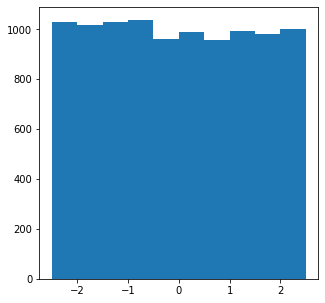

In [5]:
fig = plt.figure(figsize=(5,5))
plt.hist(p_data[:,0])

In [80]:
# define the neural network model we will use for identification
encoder = ModelBuilder.define_gaussian_process(
                                        n_input_dimensions=n_dimensions,
                                        n_output_dimensions=n_dimensions,
                                        n_parameter_dimensions=p_data.shape[1],
                                        n_layers=n_layers,
                                        n_dim_per_layer=n_dim_per_layer,
                                        name="GP",
                                        activation=ACTIVATIONS,
                                        diffusivity_type=diffusivity_type)
encoder.summary()

model = SDEApproximationNetwork(sde_model=encoder, method="euler", n_parameters=p_data.shape[1])

model.compile(optimizer=tf.keras.optimizers.Adamax(LEARNING_RATE))

sde_i = SDEIdentification(model=model)

Model: "GP_gaussian_process"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 GP_inputs (InputLayer)         [(None, 2)]          0           []                               
                                                                                                  
 GP_mean_hidden_0 (Dense)       (None, 50)           150         ['GP_inputs[0][0]']              
                                                                                                  
 GP_std_hidden_0 (Dense)        (None, 50)           150         ['GP_inputs[0][0]']              
                                                                                                  
 GP_mean_hidden_1 (Dense)       (None, 50)           2550        ['GP_mean_hidden_0[0][0]']       
                                                                                

In [81]:
hist_langevin = sde_i.train_model(x_data,y_data, p_data, step_size=step_sizes,
                                  validation_split=VALIDATION_SPLIT, n_epochs=N_EPOCHS, batch_size=BATCH_SIZE)

training for 100 epochs with 9000 data points, validating with 1000
The average loss for epoch 99 is -0.4358589718 

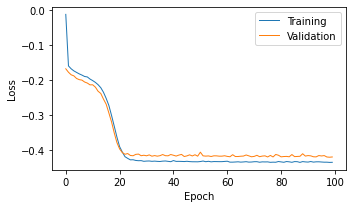

In [99]:
fig, hist_axes = plt.subplots(1, 1, figsize=(5, 3))
hist_axes.clear()
hist_axes.plot(hist_langevin.history["loss"], label='Training', linewidth=1)
hist_axes.plot(hist_langevin.history["val_loss"], label='Validation', linewidth=1)
hist_axes.legend()
hist_axes.set_xlabel('Epoch')
hist_axes.set_ylabel('Loss')

plt.gcf().tight_layout()
plt.gcf().savefig("figures/example8_nongaussian_loss.pdf")
plt.gcf().savefig("figures/example8_nongaussian_loss.png")

In [8]:
x_data.shape,y_data.shape,p_data.shape,step_sizes.shape

((10000, 1), (10000, 1), (10000, 1), (10000,))

In [9]:
print(f"Training loss final: {hist.history['loss'][-1]}")
print(f"Validation loss final: {hist.history['val_loss'][-1]}")

Training loss final: -0.4358703463386143
Validation loss final: -0.42001861106619837


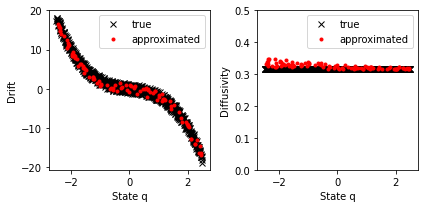

In [10]:
rng = np.random.default_rng(random_seed)

idx_p = np.argsort(p_data_test.ravel())

fig, ax = plot_parameter_functions(sde_i.drift_diffusivity, true_drift_diffusivity,
                                    x_data_test[idx_p,:], None, None,
                                    p_data=p_data_test[idx_p,:])

ax[1].set_ylim([0, .5])
ax[0].set_xlabel("State q")
ax[1].set_xlabel("State q")
plt.gcf().tight_layout()
plt.gcf().savefig("figures/example8_nongaussian_functions.pdf")
plt.gcf().savefig("figures/example8_nongaussian_functions.png")


In [24]:

def generate_results_nongaussian(apx_drift_diffusivity,
                                 step_size, x_data, rng, T_steps=25, N_iterates=10, p_data=None):
    """
    x_data is used to sample initial conditions (N*p) matrix, with N initial conditions of dimension p.
    We use a symplectic Euler method here, using x_{n+1} in the computation of v_n.
    """
    def generate_path_nongaussian(f_sigma_, _x0, N, _p0=None):
        y_next = np.zeros((N, _x0.shape[1]+1))
        y_next[0, 0] = _p0
        y_next[0, 1] = _x0
        for k in range(1, N):
            _q_k = y_next[k - 1, 0].reshape(1, -1)
            _p_k = y_next[k - 1, 1].reshape(1, -1)
            y_next[k, 0] = _q_k + step_size * _p_k  # making the SDE second order, with dx/dt = y, dy/dt = f(x,y)
            y_next[k, 1] = SDEIntegrators.euler_maruyama(_p_k,
                                                         step_size,
                                                         f_sigma_,
                                                         rng,
                                                         param=y_next[k, 0].reshape(1, -1)) # symplectic! (otherwise _q_k would be standard)
        return y_next

    time_steps = [np.arange(T_steps) * step_size] * N_iterates
    paths_ = []

    p0 = None
    for k in range(N_iterates):
        x0 = x_data[k % x_data.shape[0], :].reshape(1, -1)
        if p_data is not None:
            p0 = p_data[k % x_data.shape[0], :].reshape(1, -1)
        path_ = generate_path_nongaussian(apx_drift_diffusivity, x0, T_steps, _p0=p0)
        paths_.append(path_)

    return time_steps, paths_

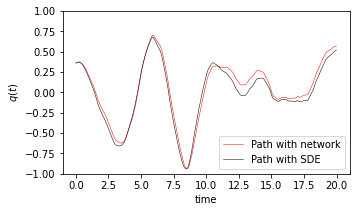

In [28]:
T_steps = int(20 / step_size)
N_iterates = 1
random_seed = 1
rng = np.random.default_rng(random_seed)

time_steps, paths_network = \
    generate_results_nongaussian(sde_i.drift_diffusivity, step_size, x_data, rng, p_data=p_data, T_steps=T_steps, N_iterates=N_iterates);

rng = np.random.default_rng(random_seed)
time_steps, paths_true = \
    generate_results_nongaussian(true_drift_diffusivity, step_size, x_data, rng, p_data=p_data, T_steps=T_steps, N_iterates=N_iterates);

# only plot the q trajectory
paths_true = [paths_true[i][:, :1] for i in range(len(paths_true))]
paths_network = [paths_network[i][:, :1] for i in range(len(paths_true))]

plot_results_1d(time_steps, paths_network, paths_true, plot_dim=0, linewidth=.5, figsize=(5, 3));
plt.gca().set_ylim([-1, 1])
plt.gca().set_ylabel(r"$q(t)$");
plt.gca().legend(['Path with network', 'Path with SDE'])

plt.gcf().savefig("figures/example8_nongaussian_path_convergence.pdf")
plt.gcf().savefig("figures/example8_nongaussian_path_convergence.png")

In [29]:
"""
Generate the probability density of all states at particular times t.
"""
T_steps = int(5 / step_size)

N_iterates = 100
n_initials = 100
t_ends = [0.5, 1.0, 10.0]
idx_ax = 0
rng = np.random.default_rng(random_seed)
tf.random.set_seed(random_seed)

data_all = []

for t_end in t_ends:
    _pn = []
    _pt = []
    print(f"Approximation until t_end={t_end}: ", end="")

    for k in range(n_initials):
        initial_condition = np.array([np.linspace(plim[0], plim[1], n_initials)[k]]).reshape(1, 1) * 0
        state_initial_condition = rng.normal(loc=0, scale=0.1, size=(1, 1))

        def gen_results_n(step_size, T_steps, N_iterates, rng):
            """
            Wrapper function so that we do not need to pass all these parameters to "probability_density".
            """
            paths = sde_i.sample_path_second_order(initial_condition, step_size, T_steps, N_iterates, param0=state_initial_condition)

            time_steps = [np.arange(T_steps) * step_size] * N_iterates
            return time_steps, paths

        def gen_results_t(step_size, T_steps, N_iterates, rng):
            """
            Wrapper function so that we do not need to pass all these parameters to "probability_density".
            """
            time_steps, paths_true = \
                generate_results_nongaussian(true_drift_diffusivity, step_size, initial_condition, rng=rng, p_data=state_initial_condition, T_steps=T_steps, N_iterates=N_iterates)

            time_steps = [np.arange(T_steps) * step_size] * N_iterates
            return time_steps, paths_true

        t0 = time()
        pn, time_steps_n, paths_n = probability_density(t=t_end, _generate_results=gen_results_n,
                                                        step_size=step_size, rng=rng, N_iterates=N_iterates)
        #print(f"sampling network took {time()-t0} seconds until t={t_end}.")

        t0 = time()
        pt, time_steps_t, paths_t = probability_density(t=t_end, _generate_results=gen_results_t,
                                                        step_size=step_size, rng=rng, N_iterates=N_iterates)
        #print(f"sampling sde took {time()-t0} seconds until t={t_end}.")
        print(f"{k}/{n_initials}", end="...")

        _pn.append(pn)
        _pt.append(pt)

    print(" Done.")
    _pn = np.row_stack(_pn)
    _pt = np.row_stack(_pt)

    n1 = pd.DataFrame(_pn[:, 0], columns=["network"])
    t1 = pd.DataFrame(_pt[:, 0], columns=["true"])

    data = pd.DataFrame(np.column_stack([n1, t1]), columns=["Network", "SDE"])

    data_all.append((t_end, data))

Approximation until t_end=0.5: 0/100...1/100...2/100...3/100...4/100...5/100...6/100...7/100...8/100...9/100...10/100...11/100...12/100...13/100...14/100...15/100...16/100...17/100...18/100...19/100...20/100...21/100...22/100...23/100...24/100...25/100...26/100...27/100...28/100...29/100...30/100...31/100...32/100...33/100...34/100...35/100...36/100...37/100...38/100...39/100...40/100...41/100...42/100...43/100...44/100...45/100...46/100...47/100...48/100...49/100...50/100...51/100...52/100...53/100...54/100...55/100...56/100...57/100...58/100...59/100...60/100...61/100...62/100...63/100...64/100...65/100...66/100...67/100...68/100...69/100...70/100...71/100...72/100...73/100...74/100...75/100...76/100...77/100...78/100...79/100...80/100...81/100...82/100...83/100...84/100...85/100...86/100...87/100...88/100...89/100...90/100...91/100...92/100...93/100...94/100...95/100...96/100...97/100...98/100...99/100... Done.
Approximation until t_end=1.0: 0/100...1/100...2/100...3/100...4/100...5

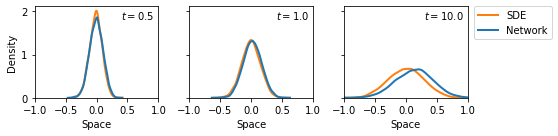

In [30]:
# plot all histograms
fig_density, ax = plt.subplots(1, len(data_all), figsize=(8, 2), sharey=True, sharex=True)

for (t_end, data) in data_all:
    p = sns.kdeplot(data=data, ax=ax[idx_ax], linewidth=2, legend=False)

    if idx_ax==2:
        # note that the legend entries must be given flipped for some reason.
        ax[idx_ax].legend(["SDE", "Network"], bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
    ax[idx_ax].text(0.97, 0.9, r"$t="+str(t_end)+"$",
                    horizontalalignment='right',
                    verticalalignment='center',
                    transform=ax[idx_ax].transAxes)
    # ax[idx_ax//2, idx_ax%2].set_xlabel(r"$x(t="+str(t_end)+")$")
    ax[idx_ax].set_xlim([-1, 1])
    ax[idx_ax].set_ylabel("Density")
    ax[idx_ax].set_xlabel("Space")

    idx_ax += 1

fig_density.tight_layout()

In [32]:
fig_density.savefig("figures/example8_nongaussian_densities.pdf")
fig_density.savefig("figures/example8_nongaussian_densities.png")

## Now we try it "the agnostic way", with the same data but assuming that there is a noise influence for q as well

In [54]:
# notebook parameters for agnostic test
n_dimensions_ag = 2  # we take both states as "state" now, no parameters

# only diagonal, so no cross-terms between p and q
diffusivity_type = "diagonal"

tf.random.set_seed(random_seed)

In [55]:
# EXAMPLE 1
def true_drift_agnostic(qp, param=None):  # no parameter used anymore
    q, p = qp[:, 0], qp[:, 1]
    return np.column_stack([p, -q**3-q - sde_gamma * p])


def true_diffusivity_agnostic(qp, param=None):
    q, p = qp[:, 0], qp[:, 1]
    _std_out = np.zeros((qp.shape[0], qp.shape[1], qp.shape[1]))
    for k in range(qp.shape[0]):
        _std_out[k, :, :] = np.diag([0, np.sqrt(2 * sde_gamma / sde_beta)])
    return _std_out


def true_drift_diffusivity_agnostic(qp, param=None):
    return true_drift_agnostic(qp, param), true_diffusivity_agnostic(qp, param)


In [108]:
rng = np.random.default_rng(random_seed)

n_pts_ag = n_pts

plim = [-2.5, 2.5]
qlim = [[plim[0]], [plim[1]]] # [low_array, high_array]. Here: we use 1d "parameter" q

# NOTE: we are artificially using "symplectic" Euler here by considering "p_data" as "x(n+1)", not "x(n)"
# However, in "sample_data" p_data is sampled at random anyway, so no changes must be made inside the method.

x_data, y_data, p_data = sample_data(true_drift_diffusivity,
                                     step_size=step_size, n_dimensions=n_dimensions,
                                     low=plim[0], high=plim[1], n_pts=n_pts_ag,
                                     rng=rng, param_low=qlim[0], param_high=qlim[1])
x_data_test, y_data_test, p_data_test = sample_data(true_drift_diffusivity,
                                                    step_size=step_size,
                                                    n_dimensions=n_dimensions,
                                                    low=plim[0], high=plim[1],
                                                    n_pts=n_pts//10, rng=rng,
                                                    param_low=qlim[0], param_high=qlim[1])
print('data shape agnostic', x_data.shape)

x_data_ag, y_data_ag = np.column_stack([p_data, x_data]), np.column_stack([p_data + step_size * x_data, y_data])
x_data_ag_test, y_data_ag_test = np.column_stack([p_data_test, x_data_test]), np.column_stack([p_data_test + step_size * x_data_test, y_data_test])

print('data shape', x_data_ag.shape)

step_sizes_ag = np.zeros((x_data_ag.shape[0],)) + step_size

data shape agnostic (10000, 1)
data shape (10000, 2)


In [109]:
# define the neural network model we will use for identification
encoder_ag = ModelBuilder.define_gaussian_process(
                                        n_input_dimensions=n_dimensions_ag,
                                        n_output_dimensions=n_dimensions_ag,
                                        n_parameter_dimensions=0,
                                        n_layers=n_layers,
                                        n_dim_per_layer=n_dim_per_layer,
                                        name="GP",
                                        activation=ACTIVATIONS,
                                        diffusivity_type=diffusivity_type)
encoder_ag.summary()

model_ag = SDEApproximationNetwork(sde_model=encoder_ag, method="euler", n_parameters=0)

model_ag.compile(optimizer=tf.keras.optimizers.Adamax(LEARNING_RATE))

sde_i_ag = SDEIdentification(model=model_ag)

Model: "GP_gaussian_process"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 GP_inputs (InputLayer)         [(None, 2)]          0           []                               
                                                                                                  
 GP_mean_hidden_0 (Dense)       (None, 50)           150         ['GP_inputs[0][0]']              
                                                                                                  
 GP_std_hidden_0 (Dense)        (None, 50)           150         ['GP_inputs[0][0]']              
                                                                                                  
 GP_mean_hidden_1 (Dense)       (None, 50)           2550        ['GP_mean_hidden_0[0][0]']       
                                                                                

In [110]:
hist_ag = sde_i_ag.train_model(x_data_ag, y_data_ag, None, step_size=step_sizes_ag,
                               validation_split=VALIDATION_SPLIT, n_epochs=N_EPOCHS * 20, # more epochs, more batch size
                               batch_size=BATCH_SIZE)

training for 2000 epochs with 9000 data points, validating with 1000
The average loss for epoch 1999 is -8.8514194450 

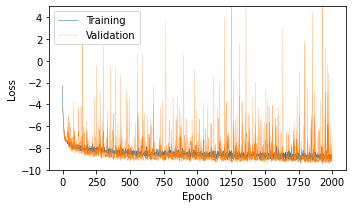

In [111]:
fig, hist_axes = plt.subplots(1, 1, figsize=(5, 3))
hist_axes.clear()
hist_axes.plot(hist_ag.history["loss"], label='Training', linewidth=.5)
hist_axes.plot(hist_ag.history["val_loss"], label='Validation', linewidth=.25)
hist_axes.legend()
hist_axes.set_xlabel('Epoch')
hist_axes.set_ylabel('Loss')
hist_axes.set_ylim([-10, 5])

plt.gcf().tight_layout()
plt.gcf().savefig("figures/example8_nongaussian_ag_loss.pdf")
plt.gcf().savefig("figures/example8_nongaussian_ag_loss.png")

In [112]:
print(f"Training loss final: {hist_ag.history['loss'][-1]}")
print(f"Validation loss final: {hist_ag.history['val_loss'][-1]}")

Training loss final: -8.851419445021065
Validation loss final: -6.987571812270175


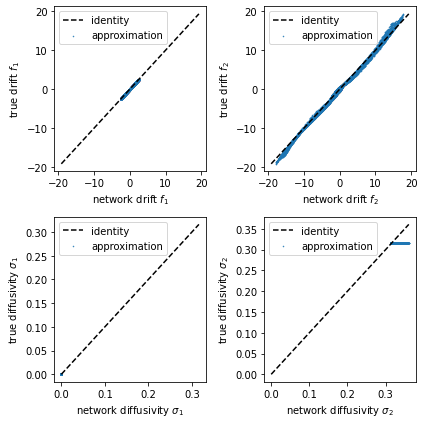

In [78]:
rng = np.random.default_rng(random_seed)

fig, ax = plot_results_functions(sde_i_ag.drift_diffusivity, true_drift_diffusivity_agnostic,
                                 x_data_ag, y_data_ag, rng,
                                 data_transform_network=None,
                                 data_transform_true=None)

plt.gcf().tight_layout()
plt.gcf().savefig("figures/example8_nongaussian_ag_functions.pdf")
plt.gcf().savefig("figures/example8_nongaussian_ag_functions.png")

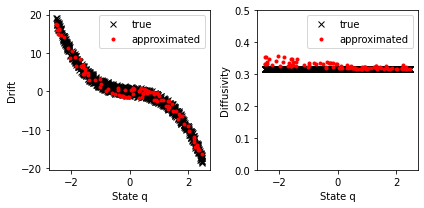

In [89]:
rng = np.random.default_rng(random_seed)

idx_p = np.argsort(p_data_test.ravel())


def extract_q_t(q, p):   # we must flip here, too, so that the network inputs are again "p, q" as trained
    _mean, _std = sde_i_ag.drift_diffusivity(p, q)
    return _mean[:, 1], _std[:, 1]


# note that we flip the x_data and p_data here so that the result is plotted over "q", not "p"
fig, ax = plot_parameter_functions(extract_q_t, true_drift_diffusivity,
                                    p_data_test[idx_p,:], None, None,
                                    p_data=x_data_test[idx_p,:])

ax[1].set_ylim([0, .5])
ax[0].set_xlabel("State q")
ax[1].set_xlabel("State q")
plt.gcf().tight_layout()
plt.gcf().savefig("figures/example8_nongaussian_ag_function1d.pdf")
plt.gcf().savefig("figures/example8_nongaussian_ag_function1d.png")


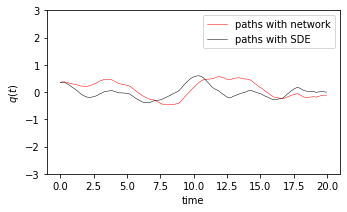

In [90]:
T_steps = int(20 / step_size)
N_iterates = 1
random_seed = 1

rng = np.random.default_rng(random_seed)

time_steps, paths_network = \
    generate_results(sde_i_ag.drift_diffusivity, step_size, x_data_ag, rng, p_data=None, T_steps=T_steps, N_iterates=N_iterates);

rng = np.random.default_rng(random_seed)

time_steps, paths_true = \
    generate_results(true_drift_diffusivity_agnostic, step_size, x_data_ag, rng, p_data=None, T_steps=T_steps, N_iterates=N_iterates);

# only plot the q trajectory
paths_true = [paths_true[i][:, :1] for i in range(len(paths_true))]
paths_network = [paths_network[i][:, :1] for i in range(len(paths_true))]

plot_results_1d(time_steps, paths_network, paths_true, plot_dim=0, linewidth=.5, figsize=(5, 3));
plt.gca().set_ylim([-3, 3])
plt.gca().set_ylabel(r"$q(t)$");

plt.gcf().savefig("figures/example8_nongaussian_ag_path_convergence.pdf")
plt.gcf().savefig("figures/example8_nongaussian_ag_path_convergence.png")
